# Figure 5 - Compare models

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-05-01 18:40:54.592988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 18:40:54.607184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 18:40:54.611296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    #'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : [  'uphp_rotated',
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    'use_coeff_channels': False,
                    'single_layer_mask': True,

                    'all_time_range': slice(3600-256, 3600),
                    #'train_time_range': slice(0, 2048),
                    #'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    #'num_train_batches': 128, 
                    #'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],

                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/main_models/window_all/shape_48_48_2/'
                    
            }

In [3]:
experiment_configs = {'1point':{'window_size':1, 'num_inputs':6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'1point'},
                      '3point':{'window_size':3, 'num_inputs':3*3*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'3point'},
                      '5point':{'window_size':5, 'num_inputs':5*5*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'5point'}    
                        }

In [4]:
%%time
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
for key in experiment_configs.keys():

    print('Starting to load in DT for: ' + key)
    
    experiment_configs[key]['DT'] = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                         filter_scales=common_config['filter_scales'], 
                         window_size = experiment_configs[key]['window_size'], 
                         time_sel = common_config['all_time_range'],
                         single_layer_mask_flag=common_config['single_layer_mask']
                         )

    print('Opening up eval sys: ' + key)
    experiment_configs[key]['eval_sys'] = evaluation.EvalSystem(simulation_data=experiment_configs[key]['DT'],
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs=experiment_configs[key]['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=experiment_configs[key]['exp_ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

    print('Reading model and predicting: ' + key)
    
    experiment_configs[key]['eval_sys'].read_ann_regression_model()
    experiment_configs[key]['eval_sys'].read_eval_data()
    experiment_configs[key]['eval_sys'].predict()
    experiment_configs[key]['eval_sys'].dimensionalize()

Starting to load in DT for: 1point
Opening up eval sys: 1point
Reading model and predicting: 1point
Starting to load in DT for: 3point
Opening up eval sys: 3point
Reading model and predicting: 3point
Starting to load in DT for: 5point
Opening up eval sys: 5point
Reading model and predicting: 5point
CPU times: user 12min 8s, sys: 2min 1s, total: 14min 9s
Wall time: 7min


In [5]:
# Make predictions using GM and VGM models 

for key in ['1point']:#experiment_configs.keys(): 
    experiment_configs[key]['eval_sys'].add_gradient_model_variables()
    experiment_configs[key]['eval_sys'].add_gent_mcwilliams_variables(lev=[1])

In [6]:
for l in common_config['filter_scales']:
    print(l, experiment_configs[key]['eval_sys'].eval_datatree.ml_dataset['P2L'][l]['kappa_gent_mcwilliams'].values)

50 137.35475573202697
100 596.2756002052041
200 2287.256437521506
400 6266.264732283053


In [7]:
for l in common_config['filter_scales']:
    print(l, experiment_configs[key]['eval_sys'].eval_datatree.ml_dataset['DG'][l]['kappa_gent_mcwilliams'].values)

50 39.53965900761229
100 104.54144546531508
200 191.5377789814487
400 107.99485362834537


In [8]:
for l in common_config['filter_scales']:
    print(l, experiment_configs[key]['eval_sys'].eval_datatree.ml_dataset['DG'][l]['c_grad_model'].values)

50 0.0747683248210061
100 0.0721502878767952
200 0.06684015592111338
400 0.04754715533766596


In [9]:
for l in common_config['filter_scales']:
    print(l, experiment_configs[key]['eval_sys'].eval_datatree.ml_dataset['P2L'][l]['c_grad_model'].values)

50 0.11399738487285781
100 0.07677721685625655
200 0.07636262152276616
400 0.09103337013738828


In [10]:
for key in ['1point']: 
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='uphp_rotated', descriptor='time', dims=['Time'])
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='vphp_rotated', descriptor='time', dims=['Time'])

    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)

In [11]:
for key in experiment_configs.keys(): 
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)

In [12]:
skill_metrics = xr.Dataset()

data_keys = list(common_config['simulation_names'])
model_keys = list(experiment_configs.keys())
model_keys.append('grad_model')
model_keys.append('gent_mcwilliams')
filter_scales = common_config['filter_scales']

R2_data = np.full((len(data_keys), len(filter_scales), len(model_keys)), np.nan)  # Initialize with NaNs
corr_data = np.full((len(data_keys), len(filter_scales), len(model_keys)), np.nan)  # Initialize with NaNs

for i, data_key in enumerate(data_keys):
    for j, model_key in enumerate(model_keys):
        for k, scale_key in enumerate(filter_scales):
        

            if model_key == 'grad_model':
                R2_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_grad_model_all.values +
                                experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_grad_model_all.values )
    
                corr_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_grad_model_all.values +
                                experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_grad_model_all.values )
            elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                R2_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_gent_mcwilliams_all.values)
    
                corr_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_gent_mcwilliams_all.values)
            else:
                R2_data[i, k, j] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_all.values +
                                experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_all.values )
    
                corr_data[i, k, j] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_all.values +
                                experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_all.values )



skill_metrics['R2'] = xr.DataArray(R2_data, coords={'data_set':data_keys,
                                                    'filter_scales':[int(x) / 5 for x in filter_scales],
                                                    'model':model_keys})
skill_metrics['corr'] = xr.DataArray(corr_data, coords={'data_set':data_keys,
                                                    'filter_scales':[int(x) / 5 for x in filter_scales],
                                                    'model':model_keys})



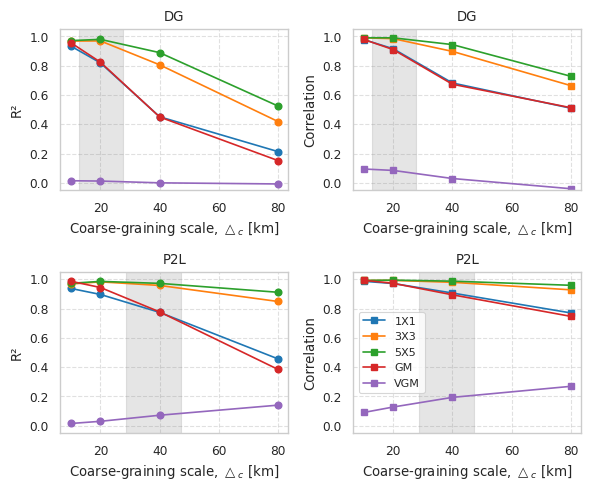

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a professional style
sns.set_context("paper")  # Larger fonts
sns.set_style("whitegrid")  # Clean background

# Define a color palette
colors = sns.color_palette("tab10", len(skill_metrics.model))

# Labels
labels = ['1X1','3X3','5X5', 'GM','VGM']

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5), constrained_layout=True)

# Loop through datasets
for i, data_key in enumerate(skill_metrics.data_set):
    # R² plot
    if data_key == 'DG':
        eddy_scale = 220
        Rd = 21
        rd_range = (12.8, 27.7)
    elif data_key == 'P2L':
        eddy_scale = 380
        Rd = 39
        rd_range = (28.7, 47.3)
    ax1 = axes[i, 0]
    for j, model_key in enumerate(skill_metrics.model):
        skill_metrics.sel(data_set=data_key, model=model_key).R2.plot(
            ax=ax1, marker='o', linestyle='-', color=colors[j], label=model_key.values
        )
    #ax1.vlines(Rd, 0, 1, linestyles='-.',  alpha=0.8)
    #rd_range = (Rd - 5, Rd + 5)
    ax1.axvspan(*rd_range, color='gray', alpha=0.2)

    ax1.set_title(f'{data_key.values}')
    ax1.set_xlabel(r'Coarse-graining scale, $\triangle_c$ [km]')
    ax1.set_ylabel('R²')
    ax1.set_ylim([-0.05, 1.05])
    #ax1.legend(fontsize=10, loc='best', frameon=True)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Correlation plot
    ax2 = axes[i, 1]
    for j, model_key in enumerate(skill_metrics.model):
        skill_metrics.sel(data_set=data_key, model=model_key).corr.plot(
            ax=ax2, marker='s', linestyle='-', color=colors[j], label=labels[j]
        )

    ax2.axvspan(*rd_range, color='gray', alpha=0.2)
    #ax2.vlines(Rd, 0, 1, linestyles='-.', alpha=0.8)
    ax2.set_title(f'{data_key.values}')
    ax2.set_xlabel(r'Coarse-graining scale, $\triangle_c$ [km]')
    ax2.set_ylabel('Correlation')
    ax2.set_ylim([-0.05, 1.05])
    
    ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=8, loc='best', frameon=True)
# Show plot
plt.tight_layout()

plt.savefig("Figures/skill_metrics_plot.png", dpi=300, bbox_inches="tight")


In [19]:
experiment_configs[key]['eval_sys'].simulation_data.simulation_data['DG']['100'].Rd.isel(Time=-1).quantile([0.1, 0.9]).values

array([12763.49440642, 27656.67277426])

In [20]:
experiment_configs[key]['eval_sys'].simulation_data.simulation_data['P2L']['100'].Rd.isel(Time=-1).quantile([0.1, 0.9]).values

array([28700.61100101, 47314.24332235])

In [35]:
np.mean(experiment_configs[key]['eval_sys'].simulation_data.simulation_data['DG']['100'].Rd/1e3).values

array(20.8904804)

In [36]:
np.mean(experiment_configs[key]['eval_sys'].simulation_data.simulation_data['P2L']['100'].Rd/1e3).values

array(39.0192046)

## Scraps

In [26]:
import xrft

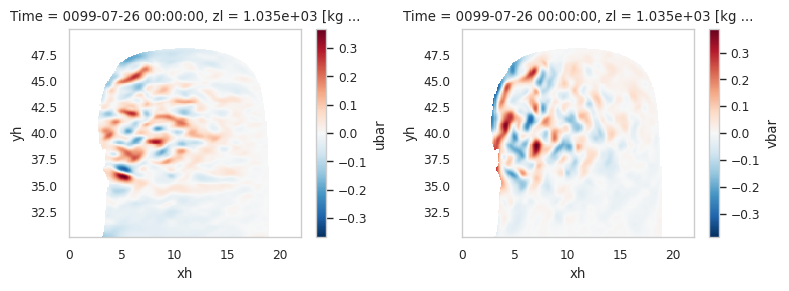

In [49]:
plt.figure(figsize=(8,3))

plt.subplot(121)
experiment_configs[key]['eval_sys'].simulation_data.simulation_data['DG']['50'].ubar.isel(Time=-1, zl=0).plot()

plt.subplot(122)
experiment_configs[key]['eval_sys'].simulation_data.simulation_data['DG']['50'].vbar.isel(Time=-1, zl=0).plot()

plt.tight_layout()

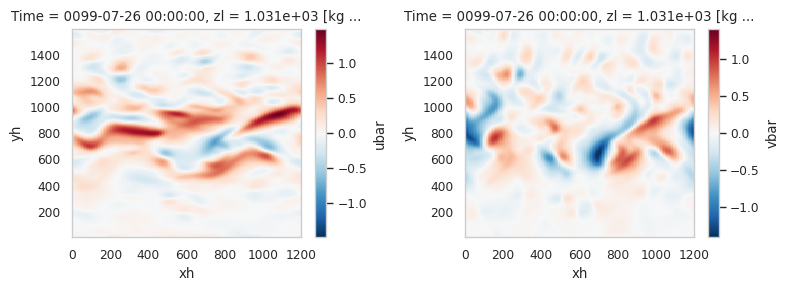

In [54]:
plt.figure(figsize=(8,3))

plt.subplot(121)
experiment_configs[key]['eval_sys'].simulation_data.simulation_data['P2L']['50'].ubar.isel(Time=-1, zl=0).plot()

plt.subplot(122)
experiment_configs[key]['eval_sys'].simulation_data.simulation_data['P2L']['50'].vbar.isel(Time=-1, zl=0).plot()

plt.tight_layout()

In [117]:
def EKE (ds = experiment_configs[key]['eval_sys'].simulation_data.simulation_data['DG']['50'].sel(xh=slice(5, 15), yh=slice(35, 45)), latlon=True):

    if latlon:
        dx = (ds.xh[1] - ds.xh[0]).values * np.cos(40 * np.pi/180) * 110
        dy = (ds.yh[1] - ds.yh[0]).values * 110
    
        nx = len(ds.xh)
        ny = len(ds.yh)
    
        x = xr.DataArray(np.arange(nx)*dx , dims='xh')
        y = xr.DataArray(np.arange(ny)*dy , dims='yh')
    
        ds['xh'] = x
        ds['yh'] = y
    
    u_mean = ds.ubar.mean('Time')
    v_mean = ds.ubar.mean('Time')
    
    u_p = ds.ubar
    v_p = ds.vbar
    
    
    ds_ps_u = xrft.isotropic_power_spectrum(u_p, nfactor=1, 
                                dim=('xh','yh'), detrend='linear', window='hann', window_correction=True).mean(['Time'])
    
    ds_ps_v = xrft.isotropic_power_spectrum(v_p, nfactor=1, 
                                dim=('xh','yh'), detrend='linear', window='hann', window_correction=True).mean(['Time'])
    
    return 0.5*(ds_ps_u + ds_ps_v)*1000.

In [122]:
EKE_DG = EKE(ds = experiment_configs[key]['eval_sys'].simulation_data.simulation_data['DG']['50'].sel(xh=slice(5, 15), yh=slice(35, 45)), latlon=True)
EKE_P2L = EKE(ds = experiment_configs[key]['eval_sys'].simulation_data.simulation_data['P2L']['50'].sel(xh=slice(50, 1150), yh=slice(50, 1550)), latlon=False)

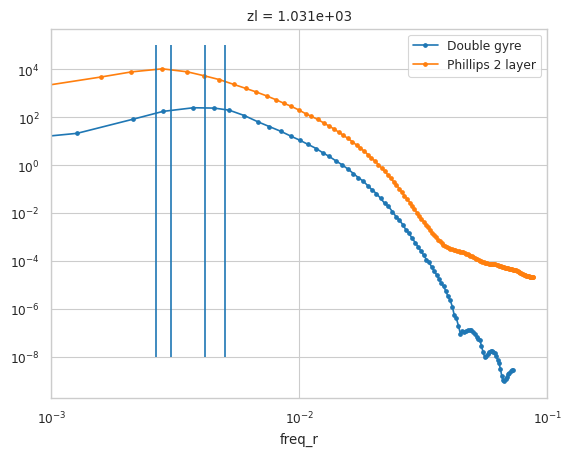

In [138]:
EKE_DG.isel(zl=0).plot(marker='.', label='Double gyre')
EKE_P2L.isel(zl=0).plot(marker='.', label='Phillips 2 layer')
plt.vlines([1/200, 1/240, 1/380, 1/330], 1e-8, 1e5)
plt.xlim([1e-3, 1e-1])
plt.xscale('log')
plt.yscale('log')

plt.legend()

In [9]:
skill_metrics = xr.Dataset()

data_keys = list(common_config['simulation_names'])
model_keys = list(experiment_configs.keys())
model_keys.append('grad_model')
model_keys.append('gent_mcwilliams')
filter_scales = common_config['filter_scales']

R2_data = np.full((len(data_keys), len(filter_scales), len(model_keys)), np.nan)  # Initialize with NaNs
corr_data = np.full((len(data_keys), len(filter_scales), len(model_keys)), np.nan)  # Initialize with NaNs

for i, data_key in enumerate(data_keys):
    for j, model_key in enumerate(model_keys):
        for k, scale_key in enumerate(filter_scales):
        

            if model_key == 'grad_model':
                R2_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_grad_model_all.values +
                                experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_grad_model_all.values )
    
                corr_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_grad_model_all.values +
                                experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_grad_model_all.values )
            elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                R2_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_gent_mcwilliams_all.values)
    
                corr_data[i, k, j] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_gent_mcwilliams_all.values)
            else:
                R2_data[i, k, j] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_all.values +
                                experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_all.values )
    
                corr_data[i, k, j] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_all.values +
                                experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_all.values )



skill_metrics['R2'] = xr.DataArray(R2_data, coords={'data_set':data_keys,
                                                    'filter_scales':list(map(int, filter_scales)),
                                                    'model':model_keys})
skill_metrics['corr'] = xr.DataArray(corr_data, coords={'data_set':data_keys,
                                                    'filter_scales':list(map(int, filter_scales)),
                                                    'model':model_keys})



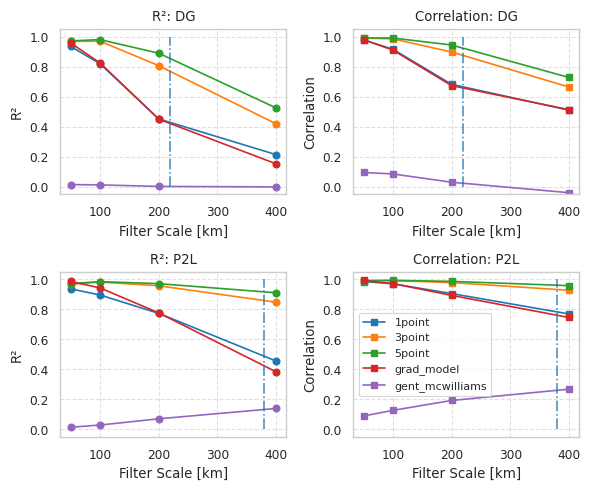

### Some maps of skill below:

kk

CPU times: user 932 ms, sys: 79.4 ms, total: 1.01 s
Wall time: 667 ms


Text(0.5, 1.0, '1point')

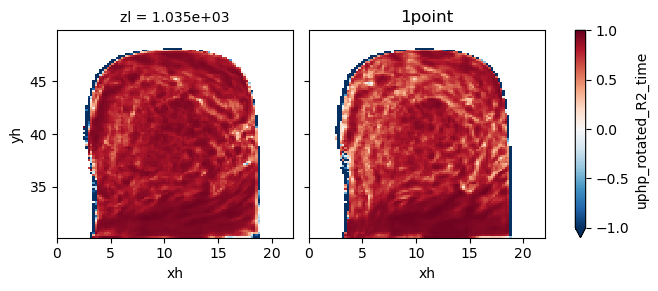

In [24]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('1point')


Text(0.5, 1.0, '1point')

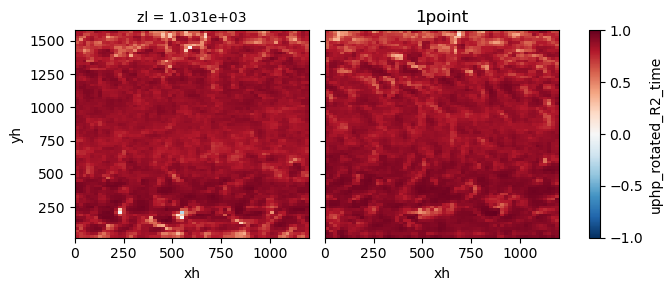

In [19]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('1point')


Text(0.5, 1.0, '3point')

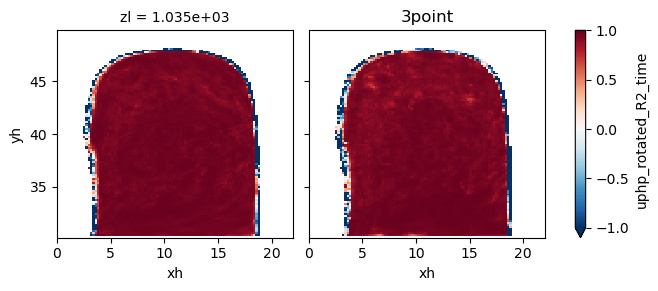

In [16]:
experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('3point')

Text(0.5, 1.0, '3point')

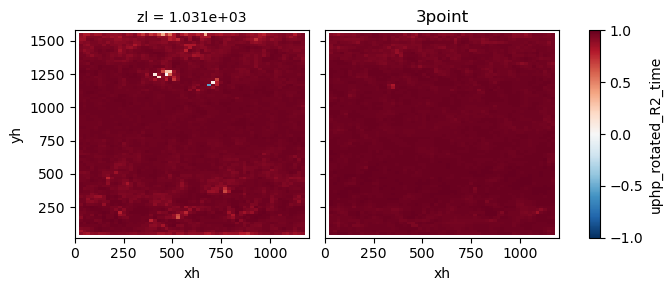

In [22]:
experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('3point')

Text(0.5, 1.0, '5point')

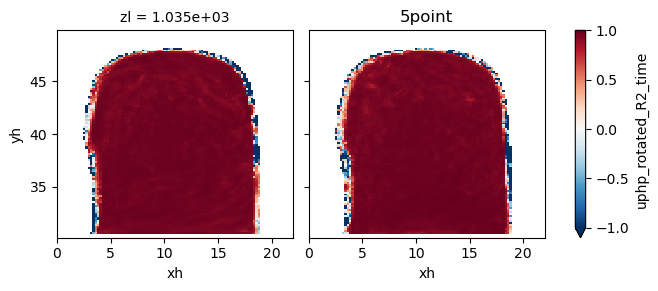

In [17]:
experiment_configs['5point']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('5point')

Text(0.5, 1.0, '5point')

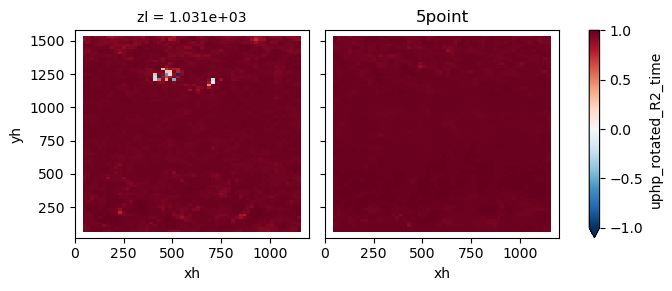

In [23]:
experiment_configs['5point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('5point')